# Imports 


In [193]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import math
import sys
from astropy.modeling.models import BlackBody
from astropy import units as u

from matplotlib import rc # for global times new roman font
from pathlib import Path
rc("font",**{"family":"serif", "serif":["Times"]})
rc("text", usetex=True)

In [194]:
runs = [1, 2, 3, 5, 6, 7]
depths = [9873.506279381681, 8934.029524345975, 8423.405023714935, 8500.143922958772, 8503.934821045383, 8390.1765008139]
errs = [51.60347163478127, 143.1915953399348, 130.688166527495, 18.52444114327136, 50.676598261274194,  129.3413199274146]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


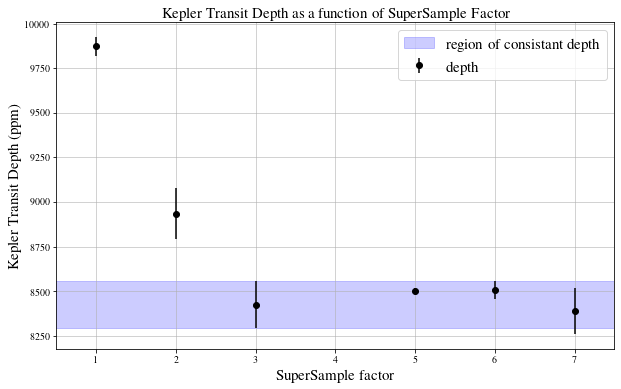

In [195]:
plt.figure(figsize=(10, 6))
plt.errorbar(runs, depths, yerr=errs, fmt="o", color="black", label="depth")

plt.fill_between(np.linspace(0, 8, 100), depths[2]-errs[2], y2=depths[2]+errs[2], color="blue", alpha=0.2, label="region of consistant depth")

plt.grid(alpha=0.7)
plt.xlim(0.5, 7.5)
plt.legend(fontsize=15)
plt.xlabel("SuperSample factor", size=15)
plt.ylabel("Kepler Transit Depth (ppm)", size=15)
plt.title("Kepler Transit Depth as a function of SuperSample Factor", size=15);

### Star Spectrum Models

In [32]:
# loads in BT-settl stellar atmosphere models 

# units of AA vs ergs/cm^2/s/AA 
spec_B_raw = np.loadtxt("lte038.0-4.5-0.0a+0.0.BT-Settl.spec.7.dat.txt")
spec_A_raw = np.loadtxt("lte058.0-4.5-0.0a+0.0.BT-Settl.spec.7.dat.txt")

### Filter transmission profiles

In [33]:
# loads in transmission profiles

# units of AA vs transmission (fraction)
kep_transmission_raw = np.loadtxt("Kepler_Kepler.K.dat")
spitz_ch1_raw = np.loadtxt("Spitzer_IRAC.I1.dat")
spitz_ch2_raw = np.loadtxt("Spitzer_IRAC.I2.dat")

### MCMC results

In [50]:
# loads in MCMC results

mcmc_output = np.load("../final_params_working.npz")
pars = mcmc_output["pars"]
errs = mcmc_output["errors"]

RpRs_kepler = [pars[4], errs[4]] 
depth_ch1 = [pars[11], errs[11]]
depth_ch2 = [pars[12], errs[12]]
depth_kepler = [pars[13], errs[13]]

print(depth_ch1)
print(depth_ch2)
print(depth_kepler)

[8062.8081528393795, 284.67063604842724]
[8247.64932897733, 244.02469776125417]
[8819.402022837698, 46.3663478735416]


### Star Radii, errors

In [35]:
# loads in star radii values, converts to correct units

to_cm = 6.95700e10 # radius of the sun in cm

RA = 1.01 * to_cm * u.cm # radius of A
sig_RA = 0.04 *to_cm * u.cm # uncertainty on radius

RB = 0.52 * to_cm * u.cm # raidus of B
sig_RB = 0.06 * to_cm * u.cm # uncertainty of radius of B

### BD radius, errors

In [36]:
# calculates Kepler radius in cm
Rp = (RpRs_kepler[0]) * RA # Assume Kepler radius is the true radius of brown dwarf, convert from RpRs -> Rp using R_A # Rp in cm

sig_Rp =(RA.value**2 * RpRs_kepler[1]** 2 + RpRs_kepler[0]**2 * sig_RA.value ** 2) ** 0.5 * u.cm
Rp_kepler = [Rp, sig_Rp] 

# Calculates $SB_{A}$, $SB_{B}$ for Kepler observation

Surface Brightness is the integral of a spectrum over wavelength 

integrate $ergs/cm^{2}/s/AA$ over $AA$ to get $ergs/cm^{2}/s$

Surface Brightness (SB) = integral of Stellar Spectrum * Transmission profile over wavelength range of filter

### Star A

In [37]:
# star A:
lam_A = spec_A_raw[:, 0] * u.AA # wavelength range of star A spectrum in AA
spectrum_A = spec_A_raw[:, 1] * u.erg/(u.cm)**2 / u.s / u.AA # spectrum of A in ergs/cm^2/s/AA : flux density

In [38]:
# Kepler transmission profile 
# indices in star wavelength array where wavelength is equal to the smallest / largest wavelength in the star spectrum array
i_min = (np.abs(spec_A_raw[:, 0] - np.min(kep_transmission_raw[:, 0]))).argmin()
i_max = (np.abs(spec_A_raw[:, 0] - np.max(kep_transmission_raw[:, 0]))).argmin()

# shortens star spectrum arrays at desired indices
spec_A = spec_A_raw[i_min:i_max]

# Creates interpolation function to transpose x axis from star data onto spitzer transmission spectrum
interp_func = interp1d(kep_transmission_raw[:, 0], kep_transmission_raw[:, 1])

# calculates new x axis, uses interpolation function to find new y axis
lam_A = spec_A[:, 0] * u.AA # wavelength from star array, adds correct units
spectrum_A = spec_A[:, 1] * (u.erg / u.cm**2 / u.s / u.AA) # grabs flux from array, adds correct units
transmission_A = interp_func(lam_A) # calculates new kepler transmission array values of same length of transmission x values

# scales flux by transmission to get array of flux of star as seen by Kepler
scaled_flux_A = transmission_A * spectrum_A

In [39]:
# integrates scaled flux(ergs/cm^2/s/A) over wavelength (A) to get flux in ergs/cm^2/s using trapezoid integration
SB_A = sum(
    [(scaled_flux_A[i] + scaled_flux_A[i-1]) * (lam_A[i] - lam_A[i-1]) / 2 for i in range(1, len(lam_A))]
)

print("Surface brightness, star A:", SB_A)

# total_flux_A gives the total flux in ergs/cm^2/s of star A as seen by Kepler. 

Surface brightness, star A: 18880651475.642326 erg / (cm2 s)


### Star B 

In [40]:
# star A:
lam_B = spec_B_raw[:, 0] * u.AA # wavelength range of star A spectrum in AA
spectrum_B = spec_B_raw[:, 1] * u.erg/(u.cm)**2 / u.s / u.AA # spectrum of A in ergs/cm^2/s/AA : flux density

In [41]:
# Kepler transmission profile 
# indices in star wavelength array where wavelength is equal to the smallest / largest wavelength in the star spectrum array
i_min = (np.abs(spec_B_raw[:, 0] - np.min(kep_transmission_raw[:, 0]))).argmin()
i_max = (np.abs(spec_B_raw[:, 0] - np.max(kep_transmission_raw[:, 0]))).argmin()

# shortens star spectrum arrays at desired indices
spec_B = spec_B_raw[i_min:i_max]

# Creates interpolation function to transpose x axis from star data onto spitzer transmission spectrum
interp_func = interp1d(kep_transmission_raw[:, 0], kep_transmission_raw[:, 1])

# calculates new x axis, uses interpolation function to find new y axis
lam_B = spec_B[:, 0] * u.AA # wavelength from star array, adds correct units
spectrum_B = spec_B[:, 1] * (u.erg / u.cm**2 / u.s / u.AA) # grabs flux from array, adds correct units
transmission_B = interp_func(lam_B) # calculates new kepler transmission array values of same length of transmission x values

# scales flux by transmission to get array of flux of star as seen by Kepler
scaled_flux_B = transmission_B * spectrum_B

In [42]:
# integrates scaled flux(ergs/cm^2/s/A) over wavelength (A) to get flux in ergs/cm^2/s using trapezoid integration
SB_B = sum(
    [(scaled_flux_B[i] + scaled_flux_B[i-1]) * (lam_B[i] - lam_B[i-1]) / 2 for i in range(1, len(lam_B))]
) 

print("Surface brightness, star B:", SB_B)


# total_flux_B gives the total flux in ergs/cm^2/s of star B as seen by Kepler. 

Surface brightness, star B: 1682994775.5774229 erg / (cm2 s)


# Calcualte SB for Spitzer channels 

### CH 1

In [43]:
# Kepler transmission profile 
# indices in star wavelength array where wavelength is equal to the smallest / largest wavelength in the star spectrum array
i_min = (np.abs(spec_A_raw[:, 0] - np.min(spitz_ch1_raw[:, 0]))).argmin()
i_max = (np.abs(spec_A_raw[:, 0] - np.max(spitz_ch1_raw[:, 0]))).argmin()

# shortens star spectrum arrays at desired indices
spec_A = spec_A_raw[i_min:i_max]

# Creates interpolation function to transpose x axis from star data onto spitzer transmission spectrum
interp_func = interp1d(spitz_ch1_raw[:, 0], spitz_ch1_raw[:, 1])

# calculates new x axis, uses interpolation function to find new y axis
lam_A = spec_A[:, 0] * u.AA # wavelength from star array, adds correct units
spectrum_A = spec_A[:, 1] * (u.erg / u.cm**2 / u.s / u.AA) # grabs flux from array, adds correct units
transmission_A = interp_func(lam_A) # calculates new kepler transmission array values of same length of transmission x values

# scales flux by transmission to get array of flux of star as seen by Kepler
scaled_flux_A_ch1 = transmission_A * spectrum_A

# integrates scaled flux(ergs/cm^2/s/A) over wavelength (A) to get flux in ergs/cm^2/s using trapezoid integration
SB_A_ch1 = sum(
    [(scaled_flux_A_ch1[i] + scaled_flux_A_ch1[i-1]) * (lam_A[i] - lam_A[i-1]) / 2 for i in range(1, len(lam_A))]
) 

print("Surface brightness, star A:", SB_A_ch1)


# total_flux_B gives the total flux in ergs/cm^2/s of star B as seen by Kepler. 

Surface brightness, star A: 209111123.36627406 erg / (cm2 s)


In [44]:
# Kepler transmission profile 
# indices in star wavelength array where wavelength is equal to the smallest / largest wavelength in the star spectrum array
i_min = (np.abs(spec_B_raw[:, 0] - np.min(spitz_ch1_raw[:, 0]))).argmin()
i_max = (np.abs(spec_B_raw[:, 0] - np.max(spitz_ch1_raw[:, 0]))).argmin()

# shortens star spectrum arrays at desired indices
spec_B = spec_B_raw[i_min:i_max]

# Creates interpolation function to transpose x axis from star data onto spitzer transmission spectrum
interp_func = interp1d(spitz_ch1_raw[:, 0], spitz_ch1_raw[:, 1])

# calculates new x axis, uses interpolation function to find new y axis
lam_B = spec_B[:, 0] * u.AA # wavelength from star array, adds correct units
spectrum_B = spec_B[:, 1] * (u.erg / u.cm**2 / u.s / u.AA) # grabs flux from array, adds correct units
transmission_B = interp_func(lam_B) # calculates new kepler transmission array values of same length of transmission x values

# scales flux by transmission to get array of flux of star as seen by Kepler
scaled_flux_B_ch1 = transmission_B * spectrum_B

# integrates scaled flux(ergs/cm^2/s/A) over wavelength (A) to get flux in ergs/cm^2/s using trapezoid integration
SB_B_ch1 = sum(
    [(scaled_flux_B_ch1[i] + scaled_flux_B_ch1[i-1]) * (lam_B[i] - lam_B[i-1]) / 2 for i in range(1, len(lam_B))]
) 

print("Surface brightness, star B:", SB_B_ch1)


# total_flux_B gives the total flux in ergs/cm^2/s of star B as seen by Kepler. 

Surface brightness, star B: 120580352.08275107 erg / (cm2 s)


### CH 2

In [45]:
# Kepler transmission profile 
# indices in star wavelength array where wavelength is equal to the smallest / largest wavelength in the star spectrum array
i_min = (np.abs(spec_A_raw[:, 0] - np.min(spitz_ch2_raw[:, 0]))).argmin()
i_max = (np.abs(spec_A_raw[:, 0] - np.max(spitz_ch2_raw[:, 0]))).argmin()

# shortens star spectrum arrays at desired indices
spec_A = spec_A_raw[i_min:i_max]

# Creates interpolation function to transpose x axis from star data onto spitzer transmission spectrum
interp_func = interp1d(spitz_ch2_raw[:, 0], spitz_ch2_raw[:, 1])

# calculates new x axis, uses interpolation function to find new y axis
lam_A = spec_A[:, 0] * u.AA # wavelength from star array, adds correct units
spectrum_A = spec_A[:, 1] * (u.erg / u.cm**2 / u.s / u.AA) # grabs flux from array, adds correct units
transmission_A = interp_func(lam_A) # calculates new kepler transmission array values of same length of transmission x values

# scales flux by transmission to get array of flux of star as seen by Kepler
scaled_flux_A_ch2 = transmission_A * spectrum_A

# integrates scaled flux(ergs/cm^2/s/A) over wavelength (A) to get flux in ergs/cm^2/s using trapezoid integration
SB_A_ch2 = sum(
    [(scaled_flux_A_ch2[i] + scaled_flux_A_ch2[i-1]) * (lam_A[i] - lam_A[i-1]) / 2 for i in range(1, len(lam_A))]
) 

print("Surface brightness, star A:", SB_A_ch2)


# total_flux_B gives the total flux in ergs/cm^2/s of star B as seen by Kepler. 

Surface brightness, star A: 121672861.878721 erg / (cm2 s)


In [46]:
# Kepler transmission profile 
# indices in star wavelength array where wavelength is equal to the smallest / largest wavelength in the star spectrum array
i_min = (np.abs(spec_B_raw[:, 0] - np.min(spitz_ch2_raw[:, 0]))).argmin()
i_max = (np.abs(spec_B_raw[:, 0] - np.max(spitz_ch2_raw[:, 0]))).argmin()

# shortens star spectrum arrays at desired indices
spec_B = spec_B_raw[i_min:i_max]

# Creates interpolation function to transpose x axis from star data onto spitzer transmission spectrum
interp_func = interp1d(spitz_ch2_raw[:, 0], spitz_ch2_raw[:, 1])

# calculates new x axis, uses interpolation function to find new y axis
lam_B = spec_B[:, 0] * u.AA # wavelength from star array, adds correct units
spectrum_B = spec_B[:, 1] * (u.erg / u.cm**2 / u.s / u.AA) # grabs flux from array, adds correct units
transmission_B = interp_func(lam_B) # calculates new kepler transmission array values of same length of transmission x values

# scales flux by transmission to get array of flux of star as seen by Kepler
scaled_flux_B_ch2 = transmission_B * spectrum_B

# integrates scaled flux(ergs/cm^2/s/A) over wavelength (A) to get flux in ergs/cm^2/s using trapezoid integration
SB_B_ch2 = sum(
    [(scaled_flux_B_ch2[i] + scaled_flux_B_ch2[i-1]) * (lam_B[i] - lam_B[i-1]) / 2 for i in range(1, len(lam_B))]
) 

print("Surface brightness, star B:", SB_B_ch2)


# total_flux_B gives the total flux in ergs/cm^2/s of star B as seen by Kepler. 

Surface brightness, star B: 71513884.7662652 erg / (cm2 s)


# Perform dilution correction on transit depths

# $\delta_{undil} = (R_{p}/R_{A})^2$

# $\delta_{diluted} = \delta_{undil} \frac{S_{A}}{S_{A} + (R_{B}/R_{A})^2 S_{B}}$


### $\delta_{undiluted} = \frac{\delta_{diluted} (S_{A} + (R_{B}/R_{A})^2 S_{B})}{S_{A}}$


Since stellar spectra are well behaved in infrared, we can approximate the dilution factor for Spitzer observations
### $\delta_{undiluted, spitzer} = \delta_{diluted} (1 + (\frac{R_{B}}{R_{A}})^2 \frac{T_{B}}{T_A})$

In [230]:
# CH 1 
dilution_ch1 = (SB_A_ch1 + (RB/RA)**2 * SB_B_ch1)/SB_A_ch1
depth_undil_ch1 = depth_ch1 * dilution_ch1

print("ch 1:", depth_undil_ch1[0], "+/-", depth_undil_ch1[1])

# CH 2
dilution_ch2 = (SB_A_ch2 + (RB/RA)**2 * SB_B_ch2)/SB_A_ch2
depth_undil_ch2 = depth_ch2 * dilution_ch2

print("ch 2:", depth_undil_ch2[0], "+/-", depth_undil_ch2[1])

# Kepler - check??? 
dilution_kepler = (SB_A+ (RB/RA)**2 * SB_B)/SB_A
depth_undil_kepler = depth_kepler * dilution_kepler

print("kepler:", depth_undil_kepler[0], "+/-", depth_undil_kepler[1])

ch 1: 9295.202445843099 +/- 328.18233328858474
ch 2: 9532.612778021246 +/- 282.04314456712495
kepler: 9027.788182862256 +/- 47.46189892821745


In [253]:
from scipy.stats import chi2
from scipy.stats import norm

observed = np.asarray([depth_undil_ch1[0], depth_undil_ch2[0], depth_undil_kepler[0]])
errs =  np.asarray([depth_undil_ch1[1], depth_undil_ch2[1], depth_undil_kepler[1]])
#errs = np.asarray([sig_depth_undil_ch1, sig_depth_undil_ch1, sig_depth_undil_kepler])
weights = 1/(errs**2)
weighted_depth = np.average(observed, weights = weights)

chi2_value = np.sum((observed - weighted_depth)**2/(errs)**2) # reduced? weighted? chi2 


dof = len(observed) - 1 # calculates degrees of freedom 
chi2_dof = chi2_value/dof

print("chi2 dof:", chi2_dof)

p_value = chi2.cdf(chi2_value, dof) # evaluates cdf to find p value 

sigma = norm.interval(p_value)[1] # converts p value to sigma interval? 
print("sigma interval:", sigma)

chi2 dof: 1.8501423071747993
sigma interval: 1.4145012114656352


In [280]:
# what do 

# write and make plots 
# start with plots - 
    # plot of depths as a function of wavelength (plot diluted and undiluted)
    # dashed line across for weighted average value 
    
    # 3 panel plot of all fit lightcurves (but one plot)
    
print(depths_undil)
print(errs_undil)

[<Quantity 9295.20244584>, <Quantity 9532.61277802>, <Quantity 9027.78818286>]
[<Quantity 328.18233329>, <Quantity 282.04314457>, <Quantity 47.46189893>]


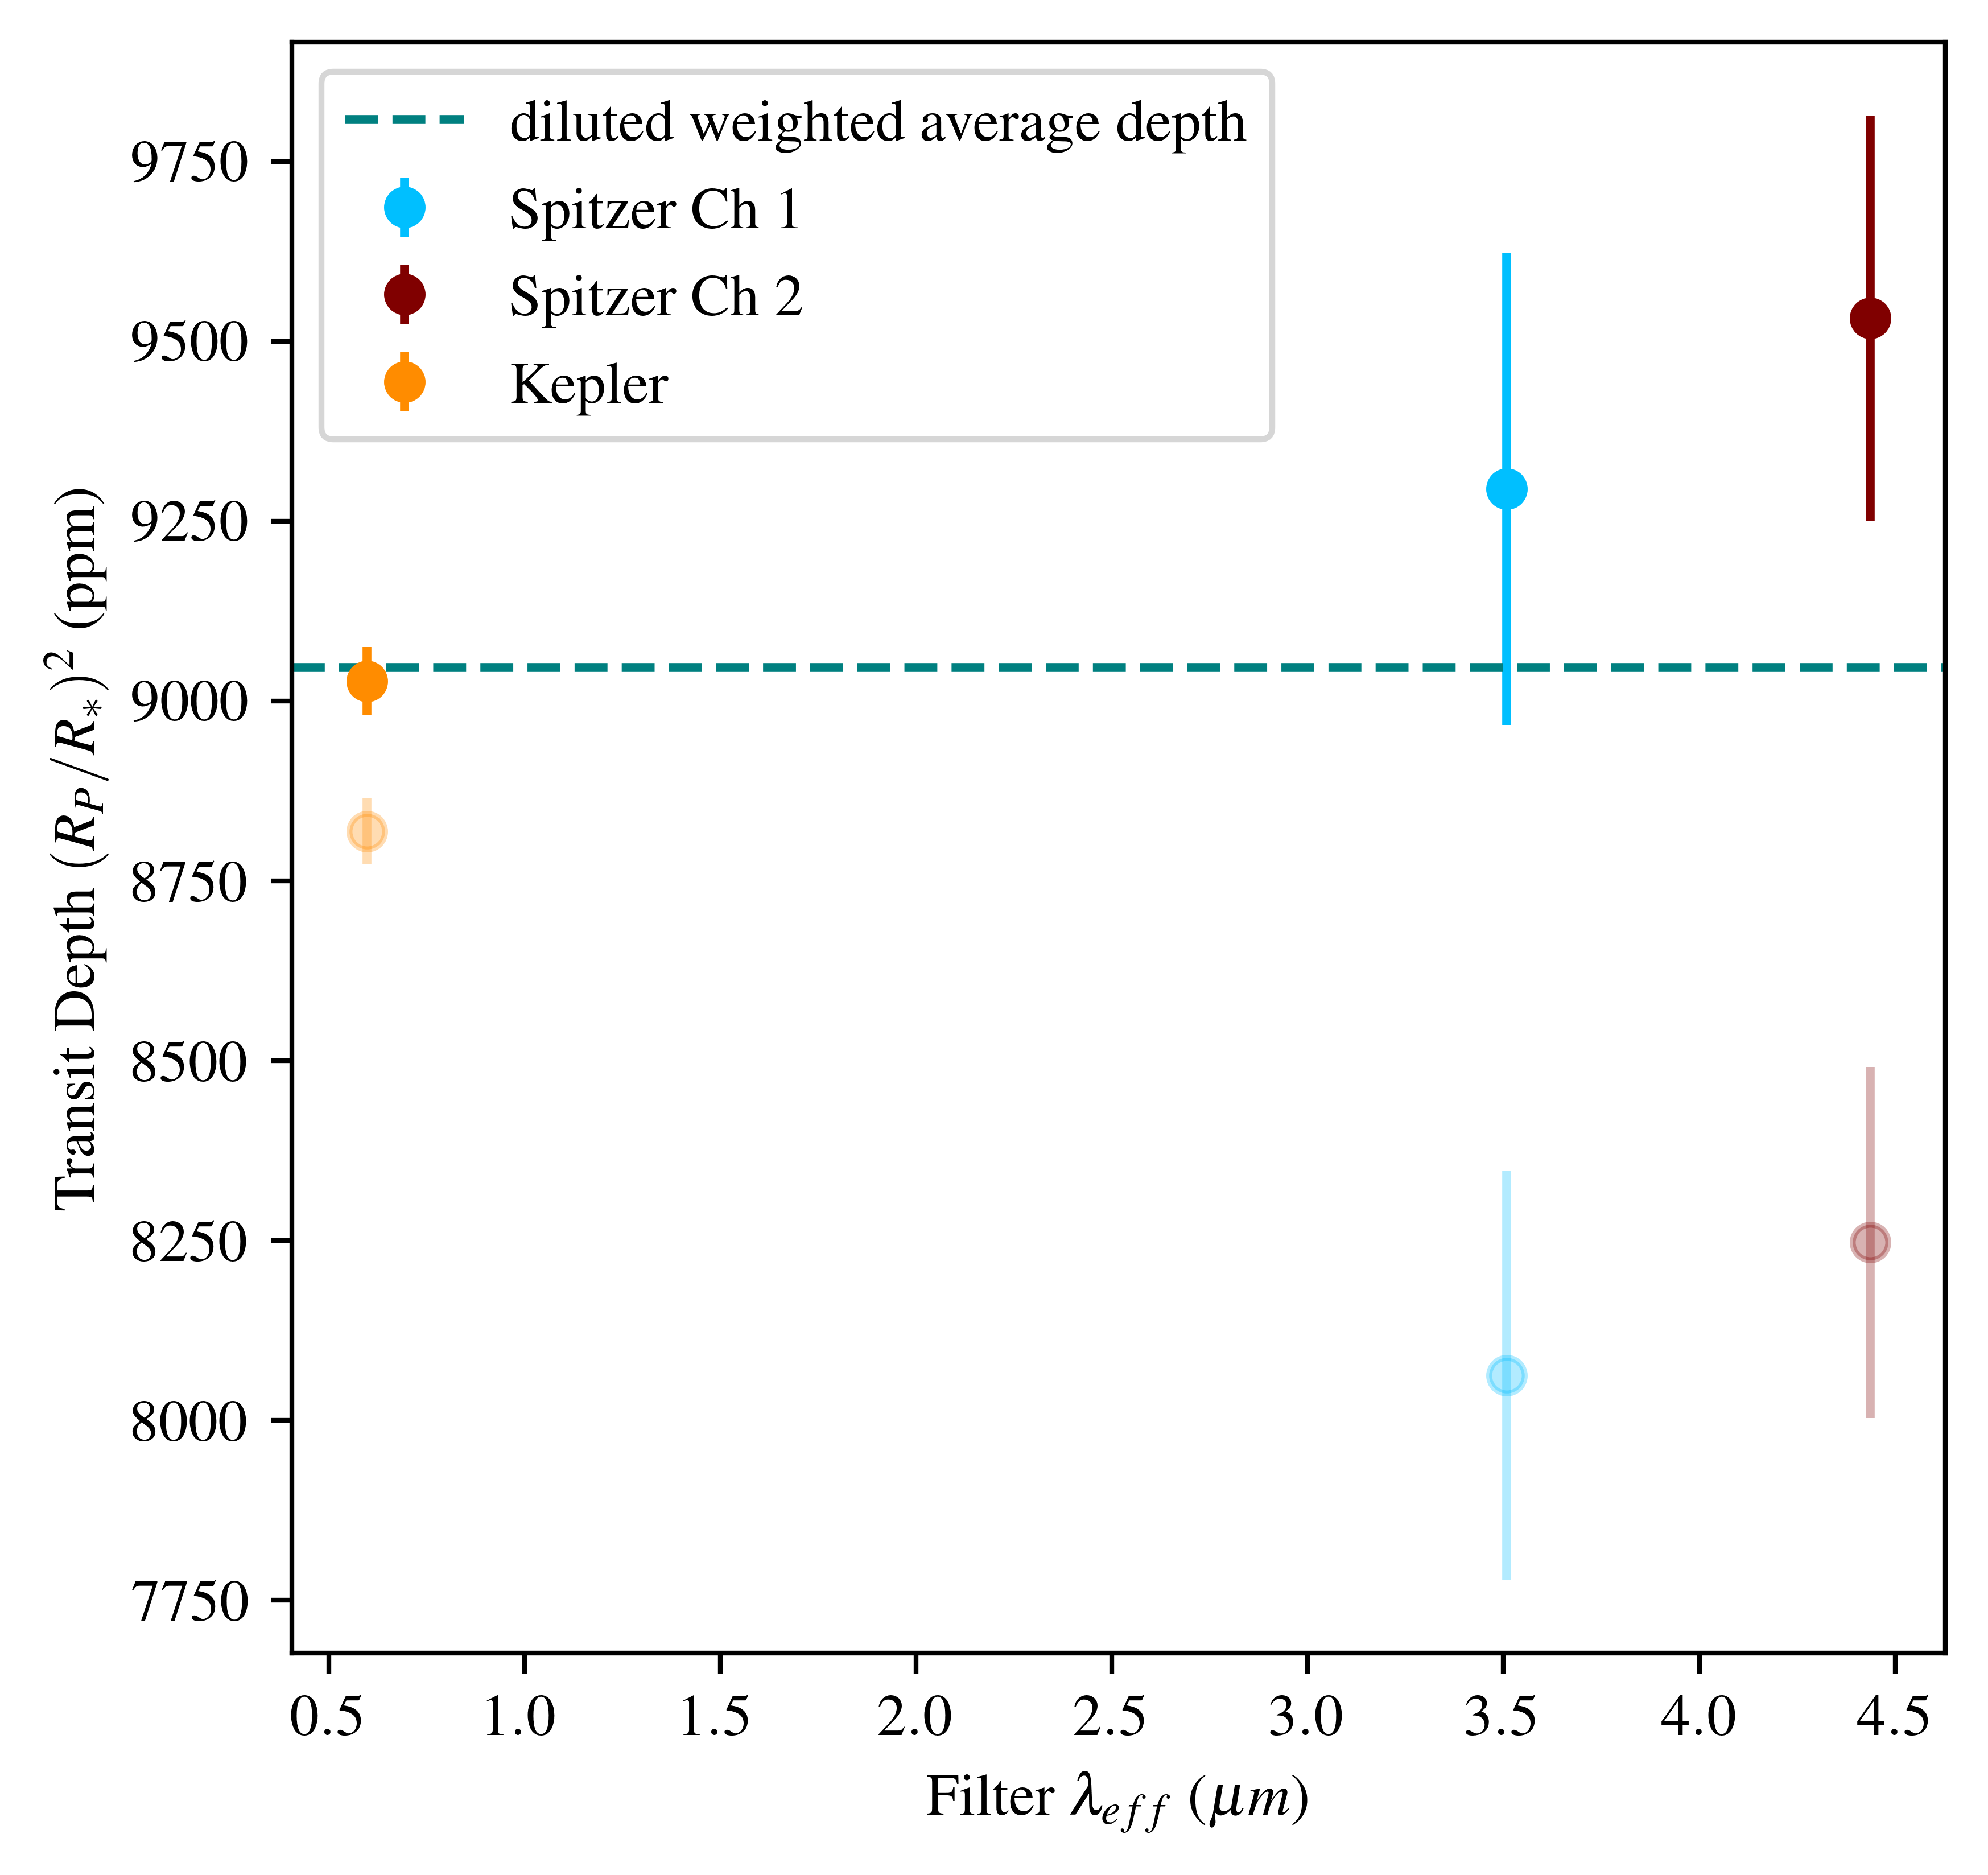

In [256]:
plt.figure(figsize=(5, 5), dpi=750)
lam = 10000 # conversion from angstroms to microns
ch1_lam = 35074.83 / lam
ch2_lam = 44365.56/ lam
kepler_lam = 5978.14/ lam

filter_lams = [ch1_lam, ch2_lam, kepler_lam]

depths_dil = [depth_ch1[0], depth_ch2[0], depth_kepler[0]]
errs_dil = [depth_ch1[1], depth_ch2[1], depth_kepler[1]]

depths_undil = [depth_undil_ch1[0], depth_undil_ch2[0], depth_undil_kepler[0]]
errs_undil = [depth_undil_ch1[1], depth_undil_ch2[1], depth_undil_kepler[1]]


labels = ["Spitzer Ch 1", "Spitzer Ch 2", "Kepler"]
lam_colors = ["deepskyblue", "maroon", "darkorange"]

for i in range (len(depths)):
    
    plt.errorbar(filter_lams[i], depths_dil[i], yerr=errs_dil[i], fmt="^", color=lam_colors[i], alpha=0.3, marker="o")
 #   plt.axhline(depths[i], color=lam_colors[i], linestyle="--", label=labels[i], alpha=0.5)
    
    plt.errorbar(filter_lams[i], depths_undil[i], yerr=errs_undil[i], fmt="^", color=lam_colors[i], label=labels[i], marker="o")
   # plt.axhline(depths[i], color=lam_colors[i], linestyle="--", label=labels[i], alpha=0.5)

plt.axhline(weighted_depth, label="diluted weighted average depth", color="teaL", linestyle="--")

#plt.title("Diluted Transit depth per wavelength of observation ")
plt.xlabel(r"Filter $\lambda_{eff}$ ($\mu m$)")
plt.ylabel("Transit Depth $(R_{P}/R_{*})^2$  (ppm)")
#plt.grid(alpha=0.1)
plt.legend(loc="upper left");

In [272]:
from scipy.stats import chi2
from scipy.stats import norm

observed = np.asarray([depth_undil_ch1[0], depth_undil_ch2[0], depth_undil_kepler[0]])
errs =  np.asarray([depth_undil_ch1[1], depth_undil_ch2[1], depth_undil_kepler[1]])
#errs = np.asarray([sig_depth_undil_ch1, sig_depth_undil_ch1, sig_depth_undil_kepler])
weights = 1/(errs**2)
weighted_depth = np.average(observed, weights = weights)
std = np.std(observed)
print(std)

weighted_var = np.average((observed - weighted_depth)**2, weights=weights)
weighted_std = np.sqrt(weighted_var)

print(weighted_depth, "+/-", weighted_std)

206.2150780530864
9046.7434637007 +/- 89.1305797799866


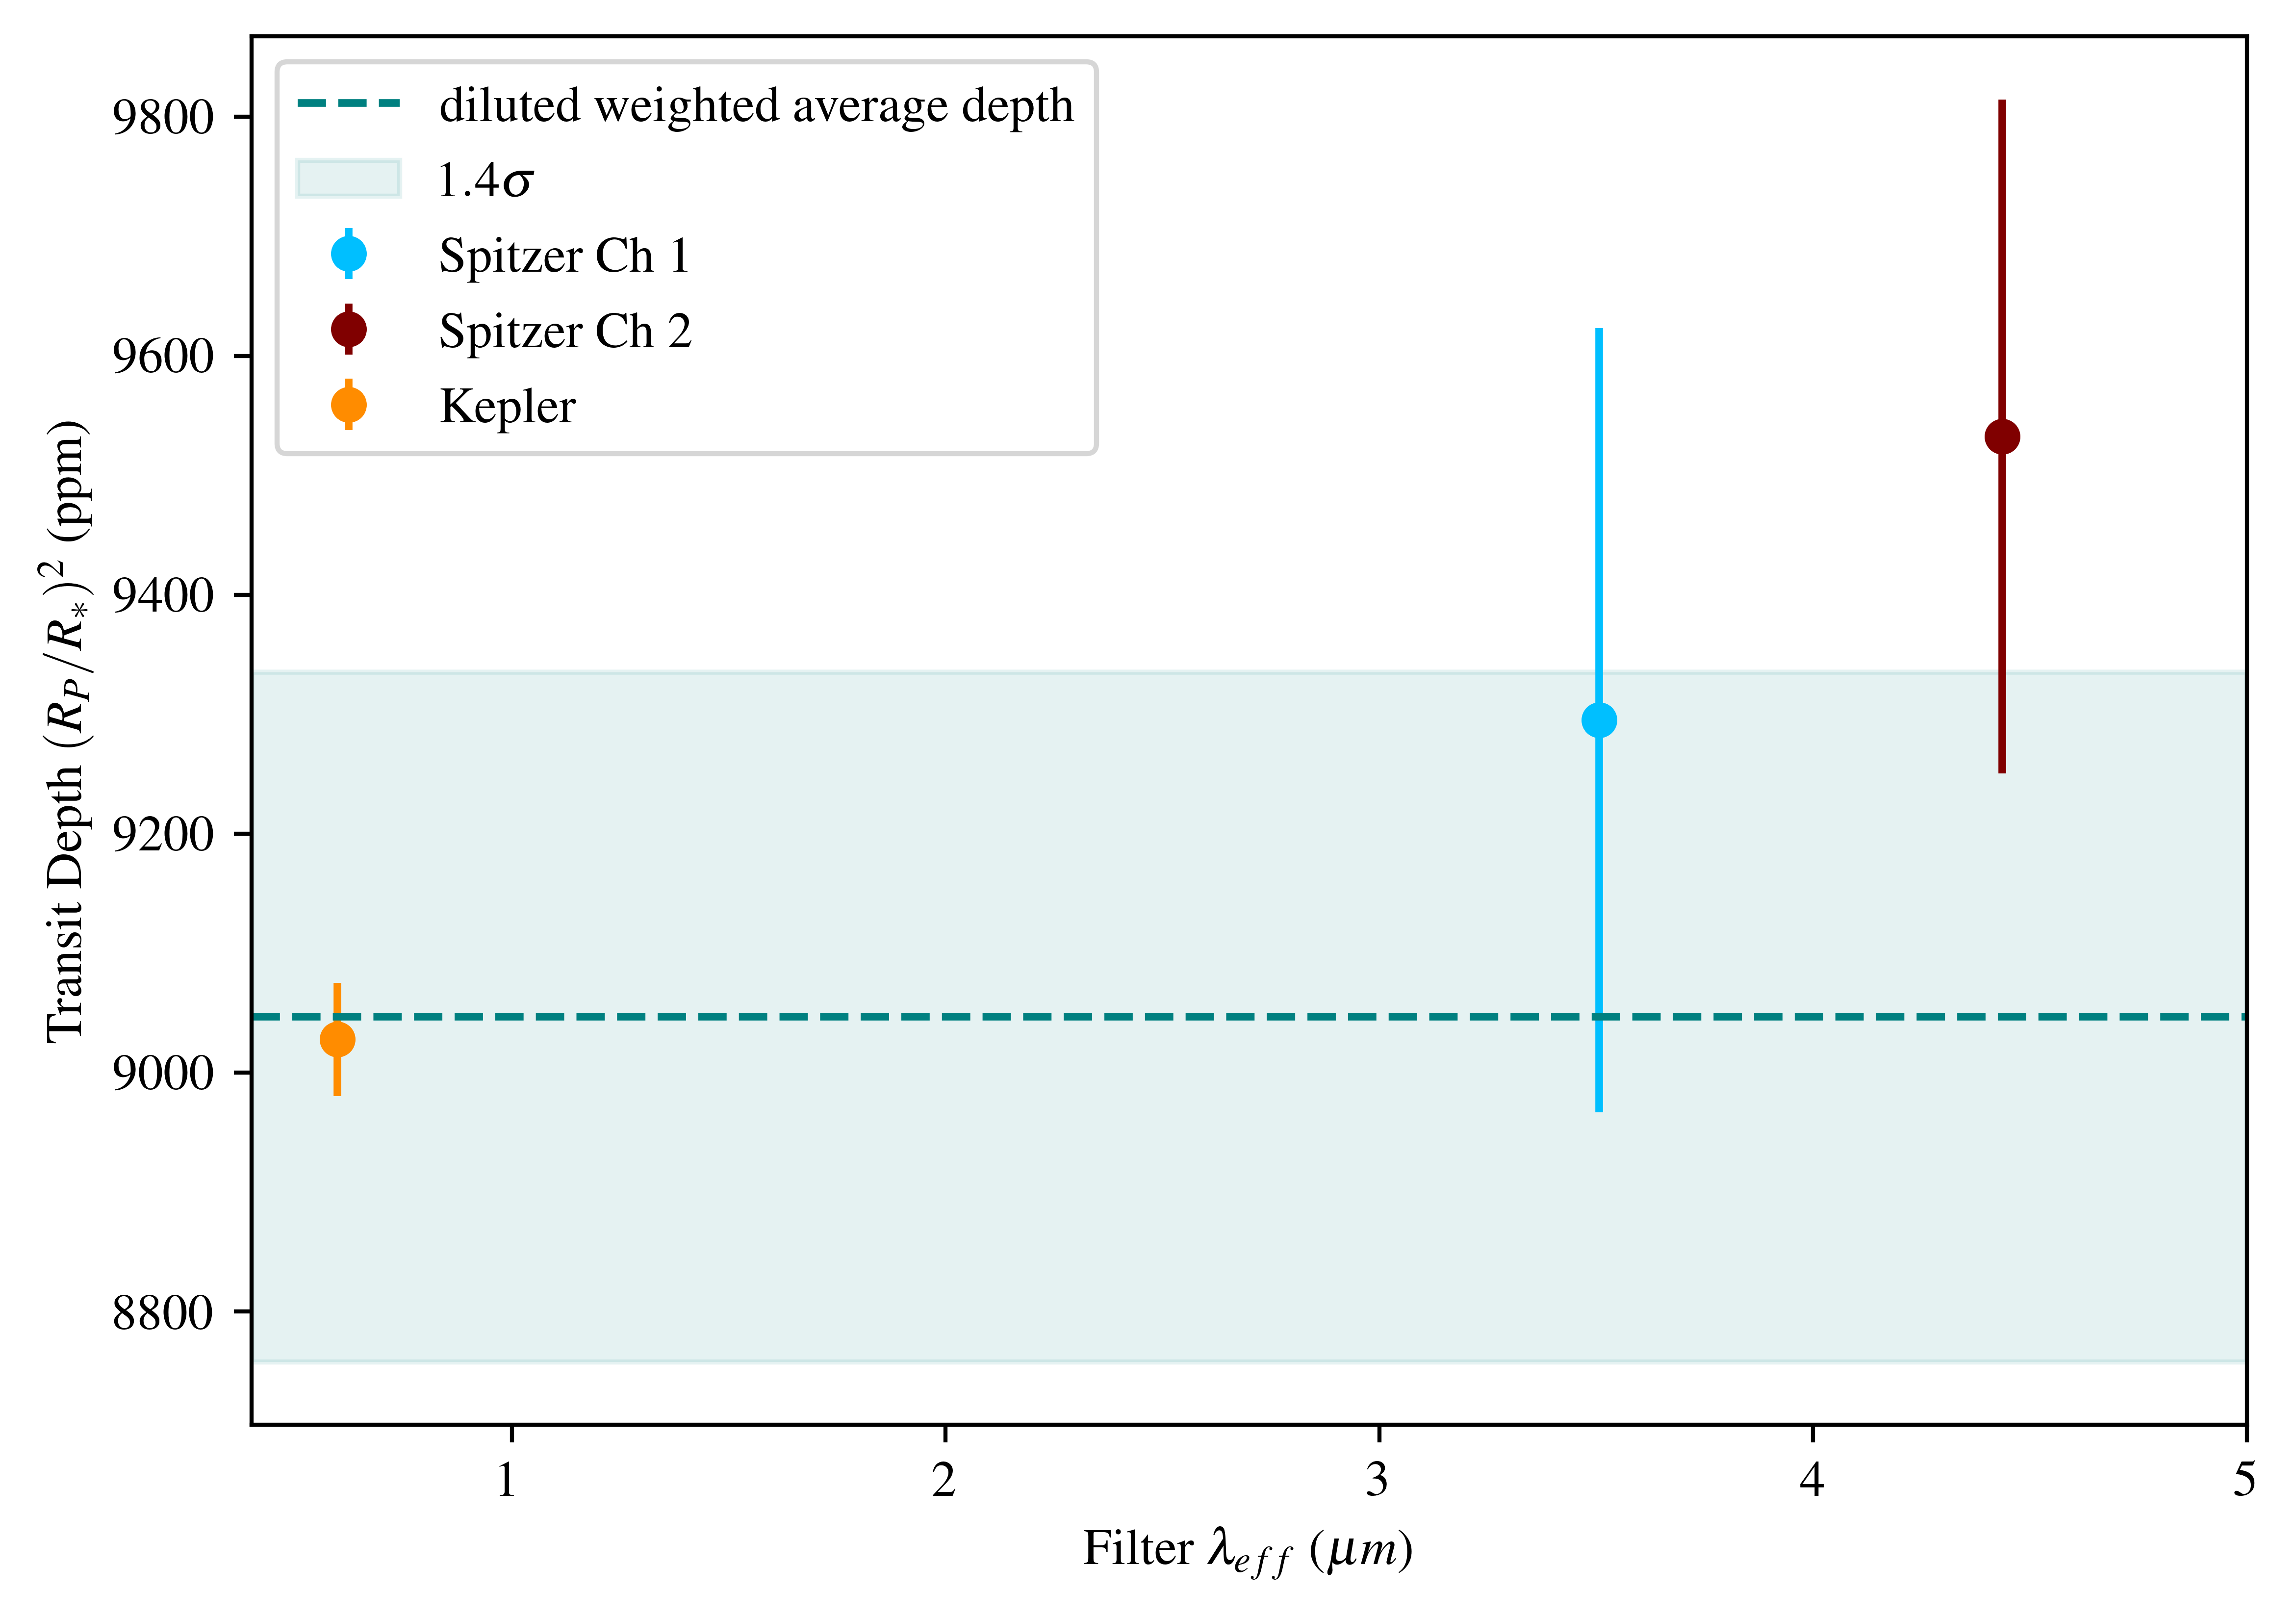

In [278]:
plt.figure(figsize=(7, 5), dpi=750)
xaxis = np.linspace(0.4, 5, 1000)

for i in range (len(depths)):
    plt.errorbar(filter_lams[i], depths_undil[i], yerr=errs_undil[i], fmt="^", color=lam_colors[i], label=labels[i], marker="o")
   # plt.axhline(depths[i], color=lam_colors[i], linestyle="--", label=labels[i], alpha=0.5)

plt.axhline(weighted_depth, label="diluted weighted average depth", color="teaL", linestyle="--")

plt.fill_between(xaxis, weighted_depth - 1.4 * std, y2=weighted_depth + 1.4 * std, color="teal", alpha=0.1, label="$1.4\sigma$")


#plt.title("Diluted Transit depth per wavelength of observation ")
plt.xlabel(r"Filter $\lambda_{eff}$ ($\mu m$)")
plt.ylabel("Transit Depth $(R_{P}/R_{*})^2$  (ppm)")
plt.xlim(0.4, 5)

plt.legend(loc="upper left");

In [354]:
import scipy.stats as st

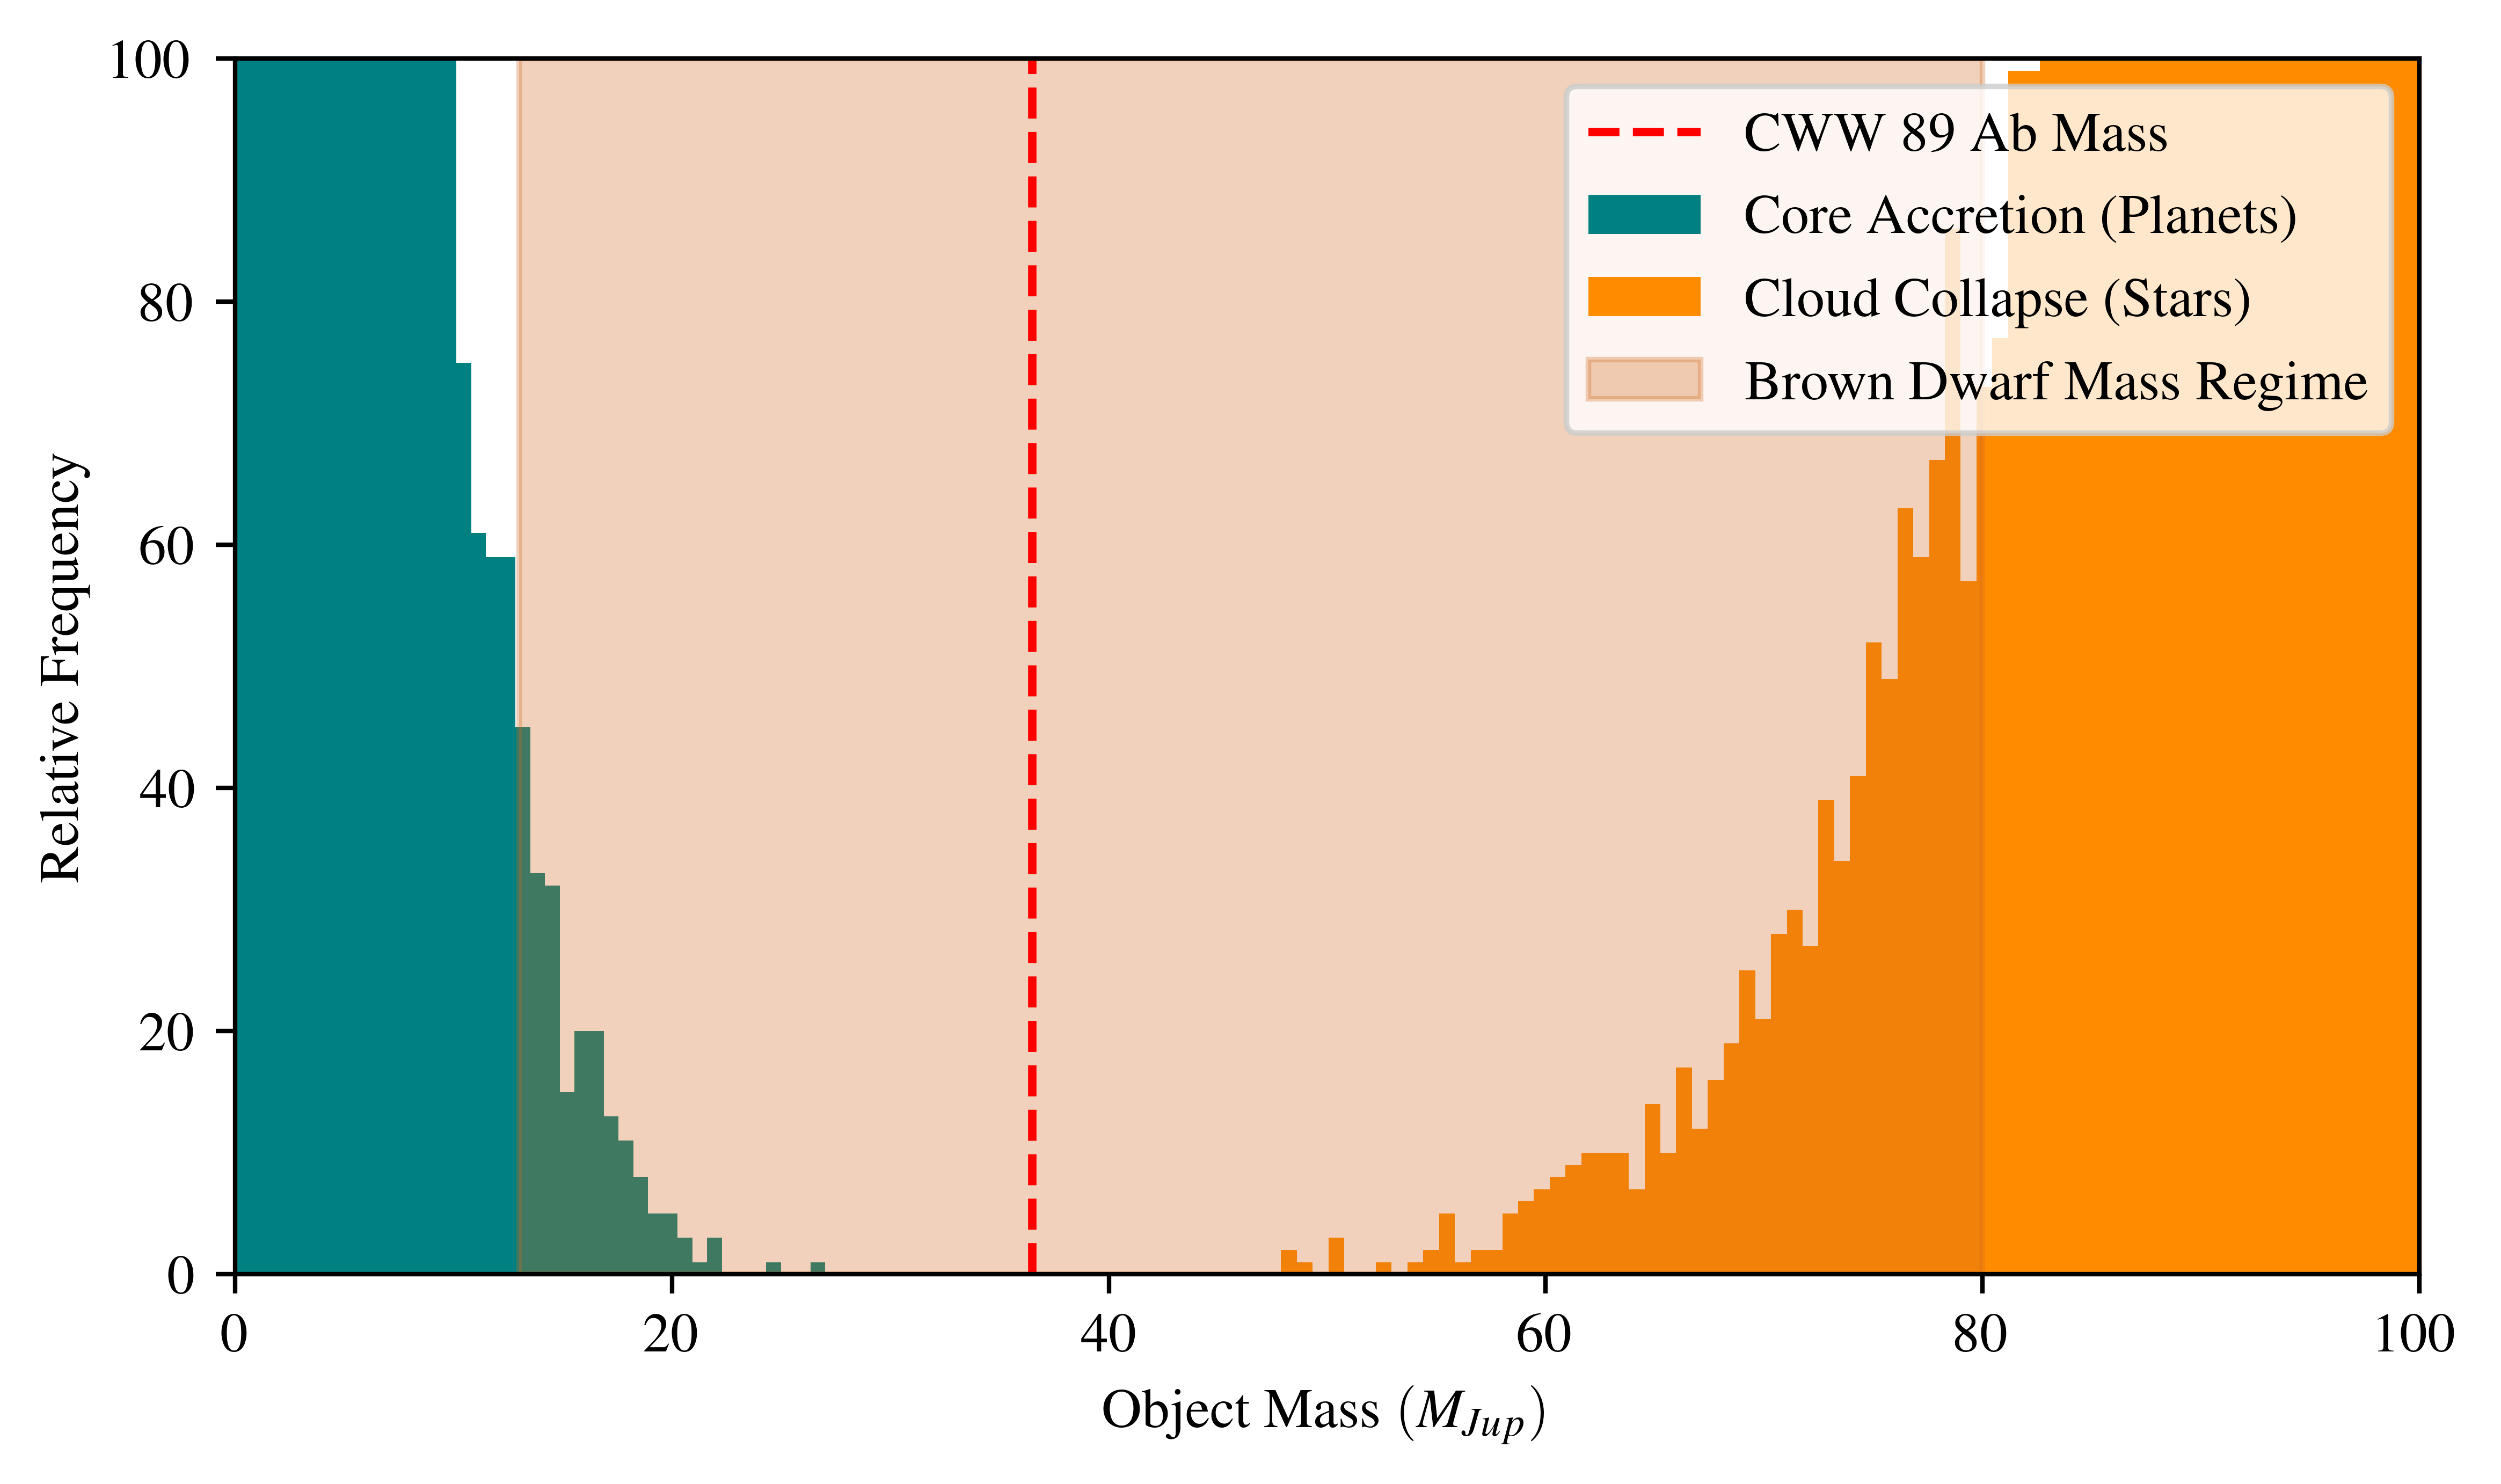

In [418]:
#plot of brightness temperature - thomas does that 
# thomas is refitting eclipses 

# Make cornerplot for all 3 - 
planets = [i for i in np.random.normal(1, 7, size=5000) if i > 0]
stars = [i for i in np.random.normal(100, 15, size=10000) if i<175]

x_planets = np.linspace(np.min(planets),70, 1000)
x_stars = np.linspace(20, np.max(stars), 1000)


plt.figure(figsize=(7, 4), dpi=750)
plt.hist(planets, bins=40, color="teal", label="Core Accretion (Planets)")

# plt.plot(x_planets, 5000*(1/(10 * np.sqrt(2 * np.pi)) *
#                np.exp( - (x_planets - 1)**2 / (2 * 10**2))),
#          linewidth=2, color='darkslategray')


# plt.plot(x_stars, 7000*(1/(15 * np.sqrt(2 * np.pi)) *
#                np.exp( - (x_stars - 100)**2 / (2 * 15**2))),
#          linewidth=2, color='orangered')


plt.axvline(36.5, color="red", linestyle="--", label="CWW 89 Ab Mass")

plt.hist(stars, bins=140, color="darkorange", label="Cloud Collapse (Stars)")
plt.axvspan(13, 80, alpha=0.3, color="chocolate", label="Brown Dwarf Mass Regime")
#plt.axvspan(25, 50, alpha=0.3, color="red", label="")
plt.xlabel("Object Mass $(M_{Jup})$")
plt.ylabel("Relative Frequency")
plt.legend(loc="upper right")
plt.xlim(0, 100)
plt.ylim(0, 100);